Introduction : Ce notebook constitue ma participation à la compétition kaggle "Spaceship Titanic". 

L'objectif de l'étude est d'utiliser et d'optimiser un algorithme de Machine Learning de classification pour prévoir si un passager à survécu ou non. 
Deux datasets sont à disposition. Le premier, train.csv, comprend la variable cible à prédire "Transported" pour l'entrainement. Le second, test.csv est utilisé pour réaliser les prédictions. Le fichier sample_submission.csv est le fichier qui servira pour stocker les prédictions et les envoyer. 

La métrique de ce concours est l'accuracy. L'objectif principal est donc de modéliser un modèle prédictif de Machine Learning maximisant l'accuracy. 

In [104]:
#Import des packages nécessaires 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import model_selection
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier

sns.set_theme(style='whitegrid', palette='pastel')

In [105]:
#Import des DataFrames 

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#Attention : toutes les modifications sur les df devront être faites dans les deux dataframes pour que l'algo de ML soit fonctionnel 

In [106]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [107]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# I) Nettoyage des données 

Pour cet analyse mettant en oeuvre des algorithmes de Machine Learning, le nettoyage et la préparation des données est une étape absolument décisive. Des hypothèses on été posées et seules celles retenues figurent dans ce notebook. 

## A) Inspection des données 

La première chose à faire avant d'explorer un jeu de données est de s'intéresser aux métadatas s'il y en a et aux informations qu'on a sur les données.
En premier lieu, d'où viennent ces données ? Comment ces données ont-elles été collectées ? Quels types de fichiers a-t-on ? De quelles tailles ? Quelles sont les caractéristiques présentes ?

In [108]:
#DataFrame train 
df_train.info()
#Il y a 8693 entrées et 14 colonnes. 
#On observe qu'il y a de nombreux NaNs dans les colonnes constituant le df. 
#Nous n'avons pas de fichier metadata à notre disposition

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [109]:
#DataFrame test
df_test.info()
#Il y a 4277 entrées et 13 colonnes. Nous n'avons pas ici la colonne target (Transported)
#On observe qu'il y a de nombreux NaNs dans les colonnes constituant le df. 
#Nous n'avons pas de fichier metadata à notre disposition.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## B) Vérification de la cohérence et de l'uniformité des données

### 1) Cohérence des données
Tout d'abord, il convient de vérifier que chaque variable est au bon type. L'objectif est d'avoir une uniformité des types de valeurs entre les 2 DataFrames.

In [110]:
#DataFrame train


#PassengerId doit être en deux colonnes (PassengerGroup et PassengerGroupNumber) et en int
df_train[['PassengerGroup','PassengerGroupNumber']]=df_train['PassengerId'].str.split('_', expand=True).astype(int)

#CryoSleep doit être en booléen
df_train.CryoSleep.unique() #A au moins un NaN, on refera une passe dessus après la gestion des valeurs manquantes

#Cabin a mettre en 3 colonnes et en object / int / object
df_train[['Deck','Num','Side']]=df_train['Cabin'].str.split('/', expand=True) #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#VIP a mettre en booléen ATTENTION BIEN REGARDER AVEC UNIQUE SI PREND BIEN 2 TRUCS
df_train['VIP'].unique() #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#Les types des variables suivantes seront traités après le traitement des valeurs manquantes
#Food court a mettre en int
#Shopping mall a mettre en int
#Spa a mettre en int 
#Age a mettre en int
#Room service a mettre en int (vérifier l'explication sur le site)

df_train.info()
df_train.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           8693 non-null   object 
 1   HomePlanet            8492 non-null   object 
 2   CryoSleep             8476 non-null   object 
 3   Cabin                 8494 non-null   object 
 4   Destination           8511 non-null   object 
 5   Age                   8514 non-null   float64
 6   VIP                   8490 non-null   object 
 7   RoomService           8512 non-null   float64
 8   FoodCourt             8510 non-null   float64
 9   ShoppingMall          8485 non-null   float64
 10  Spa                   8510 non-null   float64
 11  VRDeck                8505 non-null   float64
 12  Name                  8493 non-null   object 
 13  Transported           8693 non-null   bool   
 14  PassengerGroup        8693 non-null   int64  
 15  PassengerGroupNumber 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,1,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,1,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,1,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,1,E,608,S
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True,9280,2,E,608,S


In [111]:
#Suppression des colonnes inutiles 
df_train=df_train.drop(['PassengerId','Cabin','Name'], axis = 1)
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S


In [112]:
#DataFrame test

#PassengerId doit être en deux colonnes (PassengerGroup et PassengerGroupNumber) et en int
df_test[['PassengerGroup','PassengerGroupNumber']]=df_test['PassengerId'].str.split('_', expand=True).astype(int)

#CryoSleep doit être en booléen
df_test.CryoSleep.unique() #A au moins un NaN, on refera une passe dessus après la gestion des valeurs manquantes

#Cabin a mettre en 3 colonnes et en object / int / object
df_test[['Deck','Num','Side']]=df_test['Cabin'].str.split('/', expand=True) #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#VIP a mettre en booléen ATTENTION BIEN REGARDER AVEC UNIQUE SI PREND BIEN 2 TRUCS
df_test['VIP'].unique() #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#Les types des variables suivantes seront traités après le traitement des valeurs manquantes
#Food court a mettre en int
#Shopping mall a mettre en int
#Spa a mettre en int 
#Age a mettre en int
#Room service a mettre en int (vérifier l'explication sur le site)

df_test.info()
df_test.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           4277 non-null   object 
 1   HomePlanet            4190 non-null   object 
 2   CryoSleep             4184 non-null   object 
 3   Cabin                 4177 non-null   object 
 4   Destination           4185 non-null   object 
 5   Age                   4186 non-null   float64
 6   VIP                   4184 non-null   object 
 7   RoomService           4195 non-null   float64
 8   FoodCourt             4171 non-null   float64
 9   ShoppingMall          4179 non-null   float64
 10  Spa                   4176 non-null   float64
 11  VRDeck                4197 non-null   float64
 12  Name                  4183 non-null   object 
 13  PassengerGroup        4277 non-null   int64  
 14  PassengerGroupNumber  4277 non-null   int64  
 15  Deck                 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266,2,G,1496,S
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269,1,NaN,NaN,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271,1,D,296,P
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273,1,D,297,P
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,9277,1,G,1498,S


In [113]:
#Suppression des colonnes inutiles 
df_test=df_test.drop(['PassengerId','Cabin','Name'], axis = 1)
df_test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,13,1,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,18,1,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,19,1,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,21,1,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,23,1,F,5,S


### 2) Uniformité des données

Il convient de vérifier que les variables qualitatives sont uniformes, c'est à dire qu'elles doivent être écrites toujours de la même manière en respectant une règle unique

In [114]:
#DataFrame Train 
#Les variables qualitatives sont : HomePlanet, Destination, Age, VIP, Transported, PassengerGroupNumber, Deck, Side 
df_train['HomePlanet'].unique() #Toutes les planètes sont écrites au même format

df_train['Destination'].unique() #Toutes les destinations sont écrites au même format
#Il est décidé de simplifier les noms et de les mettre en majuscule 
df_train['Destination']=df_train['Destination'].replace('TRAPPIST-1e','TRAPPIST')
df_train['Destination']=df_train['Destination'].replace('55 Cancri e','CANCRI')
df_train['Destination']=df_train['Destination'].replace('PSO J318.5-22','PSO')
df_train['Destination'].unique() 

df_train['Age'].unique() #Tous les ages sont au même format. Après le traitement des NaNs ils seront mis en int

df_train['VIP'].unique() #Tous les VIP sont au même format et pourront donc être mis en booléen après traitement des NaNs

df_train['Transported'].unique() #Etant donné qu'il s'agit d'un booléen ce n'est pas étonnant 

df_train['PassengerGroupNumber'].unique() #Tous les numéros de groupes sont écrits au bon format 

df_train['Deck'].unique() #Tous les decks sont écrits au même format 

df_train['Side'].unique() #Tous les sides sont écrits au même format 

array(['P', 'S', nan], dtype=object)

In [115]:
#DataFrame Test
#Les variables qualitatives sont : HomePlanet, Destination, Age, VIP, Transported, PassengerGroupNumber, Deck, Side 
df_test['HomePlanet'].unique() #Toutes les planètes sont écrites au même format

df_test['Destination'].unique() #Toutes les destinations sont écrites au même format
#Il est décidé de simplifier les noms et de les mettre en majuscule 
df_test['Destination']=df_test['Destination'].replace('TRAPPIST-1e','TRAPPIST')
df_test['Destination']=df_test['Destination'].replace('55 Cancri e','CANCRI')
df_test['Destination']=df_test['Destination'].replace('PSO J318.5-22','PSO')
df_test['Destination'].unique()

df_test['Age'].unique() #Tous les ages sont au même format. Après le traitement des NaNs ils seront mis en int

df_test['VIP'].unique() #Tous les VIP sont au même format et pourront donc être mis en booléen après traitement des NaNs

df_test['PassengerGroupNumber'].unique() #Tous les numéros de groupes sont écrits au bon format 

df_test['Deck'].unique() #Tous les decks sont écrits au même format 

df_test['Side'].unique() #Tous les sides sont écrits au même format 


array(['S', 'P', nan], dtype=object)

## C) Détection et traitement des doublons

In [116]:
print('Il y a',df_train.duplicated().sum(),'doublons dans le df train')
print('Il y a',df_test.duplicated().sum(),'doublons dans le df test')

Il y a 0 doublons dans le df train
Il y a 0 doublons dans le df test


## D) Détection et traitement des valeurs manquantes

Cette étape du nettoyage des jeux de données est critique pour les algorithmes de Machine Learning. Le traitement des NaNs aura nécessairement une influence sur le résultat final. Il convient donc de prendre les meilleurs hypothèses et d'en explorer plusieurs.

L'objectif est de supprimer un minimum de données car plus on supprime de données, moins l'algorithme de Machine Learning aura de données pour s'entraîner. A contrario, si les NaNs sont remplacés par de mauvaises valeurs, cela bièsera l'algorithme. 

In [117]:
#Analyse globale
display(pd.DataFrame(df_train.isna().sum(), columns=["Nombre de NA df train"]))
display(pd.DataFrame(df_test.isna().sum(), columns=["Nombre de NA df test"]))
#Oh. My. God.

,Nombre de NA df train
HomePlanet,201
CryoSleep,217
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208
Spa,183
VRDeck,188


,Nombre de NA df test
HomePlanet,87
CryoSleep,93
Destination,92
Age,91
VIP,93
RoomService,82
FoodCourt,106
ShoppingMall,98
Spa,101
VRDeck,80


### a) Traitement des valeurs manquantes numériques

Dans un premier temps nous allons suivre les hypothèses suivantes :
- Pour l'âge nous allons remplacer les NaNs par la moyenne
- Pour RoomService, FoodCourt, ShoppingMall, Spa et VRDeck nous allons remplacer les NaNs par 0 

Il sera intéressant de faire autrement dans une seconde analyse afin d'observer l'influence de ces paramètres sur l'Accuracy des algorithmes de ML. 

In [118]:
#On trie le df pour n'avoir que les valeurs numériques 
df_train.select_dtypes(include='number').isna().any()

#DataFrame train

#Age
AgeMean=df_train['Age'].mean().round(0)
df_train['Age']=df_train['Age'].fillna(AgeMean)
#RoomService, FoodCourt, ShoppingMall, Spa et VRDeck
df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]=df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

#DataFrame test

#Age
AgeMean=df_test['Age'].mean().round(0) #Les moyennes d'age sont les mêmes dans les deux df
df_test['Age']=df_test['Age'].fillna(AgeMean)
#RoomService, FoodCourt, ShoppingMall, Spa et VRDeck
df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]=df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

### b) Traitement des valeurs manquantes catégorielles

Dans un premier temps nous allons suivre les hypothèses suivantes. 
Etant donné que les valeurs ont été renseignées de manière ordonnée : 
- Pour HomePlanet, CryoSleep, nous allons chercher une logique avec les proches voisins 
- Pour CryoSleep aller chercher sur internet les distances : Peut etre que ceux qui viennent de plus loin ont décidé de se cryo
- Pour VIP nous allons chercher une corrélation entre les dépenses annexes. En effet, on fait l'hypothèse qu'une personne ayant acheté des services à bord est plus susceptible d'avoir pris une formule VIP. Cependant, il faut garder à l'esprit que cet hypothèse est directement corrélée à l'hypothèse précédente sur les dépenses à bord
- Pour Deck, Num et side nous allons chercher une logique avec les proches voisins. En effet, l'énoncé du concours indique que parfois certains passagers sont en famille. On peut également faire l'hypothèses (qui sera à vérifier en parcourant le dataset) que les passagers de mêmes groupes ont leur cabines à coté. 

In [119]:
df_train.Deck.value_counts()


Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

In [120]:
#On trie le df pour n'avoir que les valeurs catégorielles 

#DataFrame train

#Destination
data=df_train.pivot_table(index='HomePlanet', columns='Destination', aggfunc='size', fill_value=0)
data=data.reset_index() #On observe que la plupart des gens vont à TRAPPIST. On décide donc de remplacer les NaNs 
df_train['Destination']=df_train['Destination'].fillna('TRAPPIST')

#HomePlanet 
vip=df_train.pivot_table(index='HomePlanet', columns='VIP', aggfunc='size', fill_value=0)
vip=vip.reset_index() #On remarque qu'aucune personne venant de Earth n'est VIP. 
df_train.loc[(df_train['HomePlanet'].isna()) & (df_train['VIP'] == True)]#On sait donc que ceux-là (291, 365, 405, 7042 et 7786) ne sont pas de Earth
pd.crosstab(df_train.Destination, df_train.HomePlanet, normalize=0) 
#91% des gens qui vont à PSO viennent de Earth, 50% des gens qui vont à Cancri viennent d'Europa et 53% des gens qui vont à Trappist viennent de Earth 
#On met donc en place la boucle suivante pour associer à chaque NaN la HomePlanet la plus probable 
for index, row in df_train.iterrows(): #On parcourt chaque ligne du DataFrame
    if pd.isna(row['HomePlanet']): #On vérifie que la valeur est bien un NaN
        if row['Destination'] == 'CANCRI':
            df_train.at[index, 'HomePlanet'] = 'Europa'
        elif row['Destination'] == 'PSO':
            df_train.at[index, 'HomePlanet'] = 'Earth'
        elif row['Destination'] == 'TRAPPIST':
            df_train.at[index, 'HomePlanet'] = 'Earth'
pd.crosstab(df_train.Destination, df_train.HomePlanet, normalize=0) #On vérifie et OK, on a presque la même distribution 

#VIP
df_train.VIP.value_counts(normalize=True) #On observe que 97% des passagers n'est pas en VIP. On remplace donc par le mode 
df_train['VIP']=df_train['VIP'].fillna(df_train['VIP'].mode()[0])

#CryoSleep 
df_train.CryoSleep.value_counts(normalize=True) #On observe que 65% des passagers on choisi CryoSleep. Pas assez pour remplacer par le mode.  
pd.crosstab(df_train.CryoSleep, df_train.VIP, normalize=1) #89% des VIP ne se cryogénisent pas donc si VIP = cryo non 
for index, row in df_train.iterrows():
    if pd.isna(row['CryoSleep']):
        if row['VIP'] == 'True':
            df_train.at[index, 'CryoSleep'] = False
        else:
            df_train.at[index, 'CryoSleep'] = True

#Deck, Num, Side 
#On observe que Deck, Num et side sont toujours simultanément des NaNs ensemble
#Dans un premier temps je ne parviens pas à observer des liens me permettant de corriger ces NaNs. 
#Pour avancer je supprime ces NaNs en gardant à l'esprit que cela jouera sur l'Accuracy (il constituent 2% du dataset)
df_train=df_train.dropna(axis = 0, how = 'any')


#DataFrame test

#Destination
df_test['Destination']=df_test['Destination'].fillna('TRAPPIST')

#HomePlanet
for index, row in df_test.iterrows():
    if pd.isna(row['HomePlanet']):
        if row['Destination'] == 'CANCRI':
            df_test.at[index, 'HomePlanet'] = 'Europa'
        elif row['Destination'] == 'PSO':
            df_test.at[index, 'HomePlanet'] = 'Earth'
        elif row['Destination'] == 'TRAPPIST':
            df_test.at[index, 'HomePlanet'] = 'Earth'

#VIP
df_test['VIP']=df_test['VIP'].fillna(df_test['VIP'].mode()[0])

#CryoSleep 
for index, row in df_test.iterrows():
    if pd.isna(row['CryoSleep']):
        if row['VIP'] == 'True':
            df_test.at[index, 'CryoSleep'] = False
        else:
            df_test.at[index, 'CryoSleep'] = True

#Deck, Num, Side 
df_test=df_test.dropna(axis = 0, how = 'any')


/var/folders/vy/jvxs5wcd4zgg3k_p9qn7y39c0000gn/T/ipykernel_14643/3537099495.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['VIP']=df_train['VIP'].fillna(df_train['VIP'].mode()[0])
/var/folders/vy/jvxs5wcd4zgg3k_p9qn7y39c0000gn/T/ipykernel_14643/3537099495.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['VIP']=df_test['VIP'].fillna(df_test['VIP'].mode()[0])


In [121]:
#Vérification finale : 
display(pd.DataFrame(df_train.isna().sum(), columns=["Nombre de NA df train"]))
display(pd.DataFrame(df_test.isna().sum(), columns=["Nombre de NA df test"]))

,Nombre de NA df train
HomePlanet,0
CryoSleep,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0
VRDeck,0


,Nombre de NA df test
HomePlanet,0
CryoSleep,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0
VRDeck,0


## E) Deuxieme passe de traitement de la cohérence des données 

Certaines variabes n'ont pas pu être traitées avant le traitement des NaNs car ils en contenaient

In [122]:
#DataFrame Train
df_train['CryoSleep']=df_train['CryoSleep'].astype(bool)
df_train[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']]=df_train[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']].astype(int)


#Age a mettre en int
#Room service a mettre en int (vérifier l'explication sur le site)

#DataFrame Test
df_test['CryoSleep']=df_test['CryoSleep'].astype(bool)
df_test[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']]=df_test[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']].astype(int)


## F) Détection et traitement des Outliers
Ce traitement ne concerne que les variables quantitatives

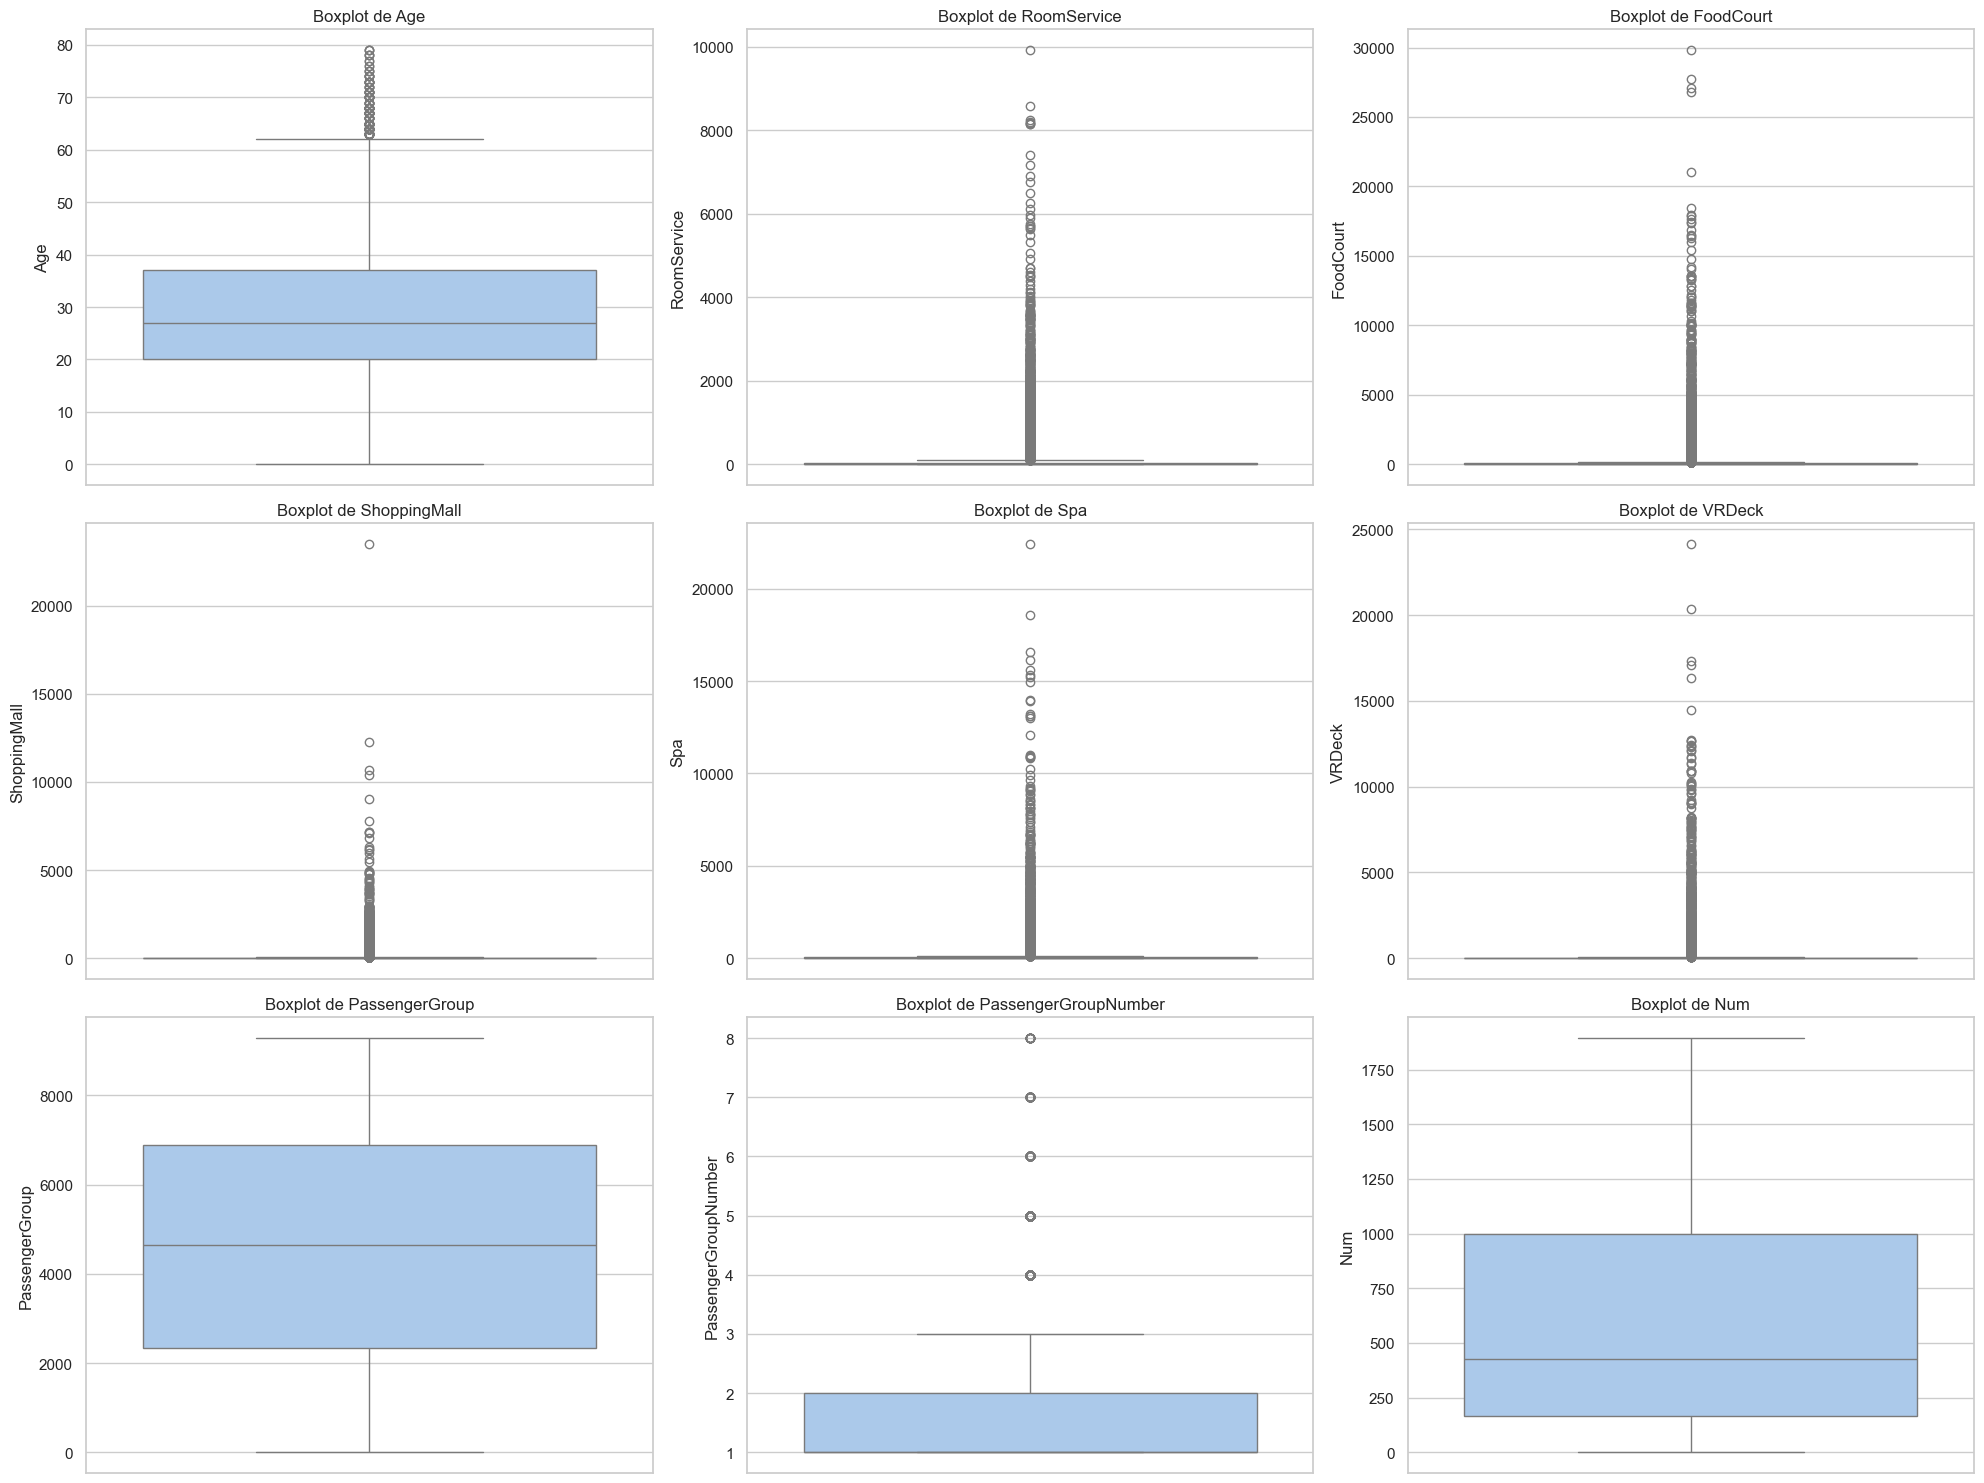

In [141]:
num=df_train.select_dtypes(include='number')
columns = num.columns

plt.figure(figsize=(20, 15)) 
for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=num[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

#On observe qu'il y a des outliers mais qui ne constituent pas des valeurs aberrantes. 

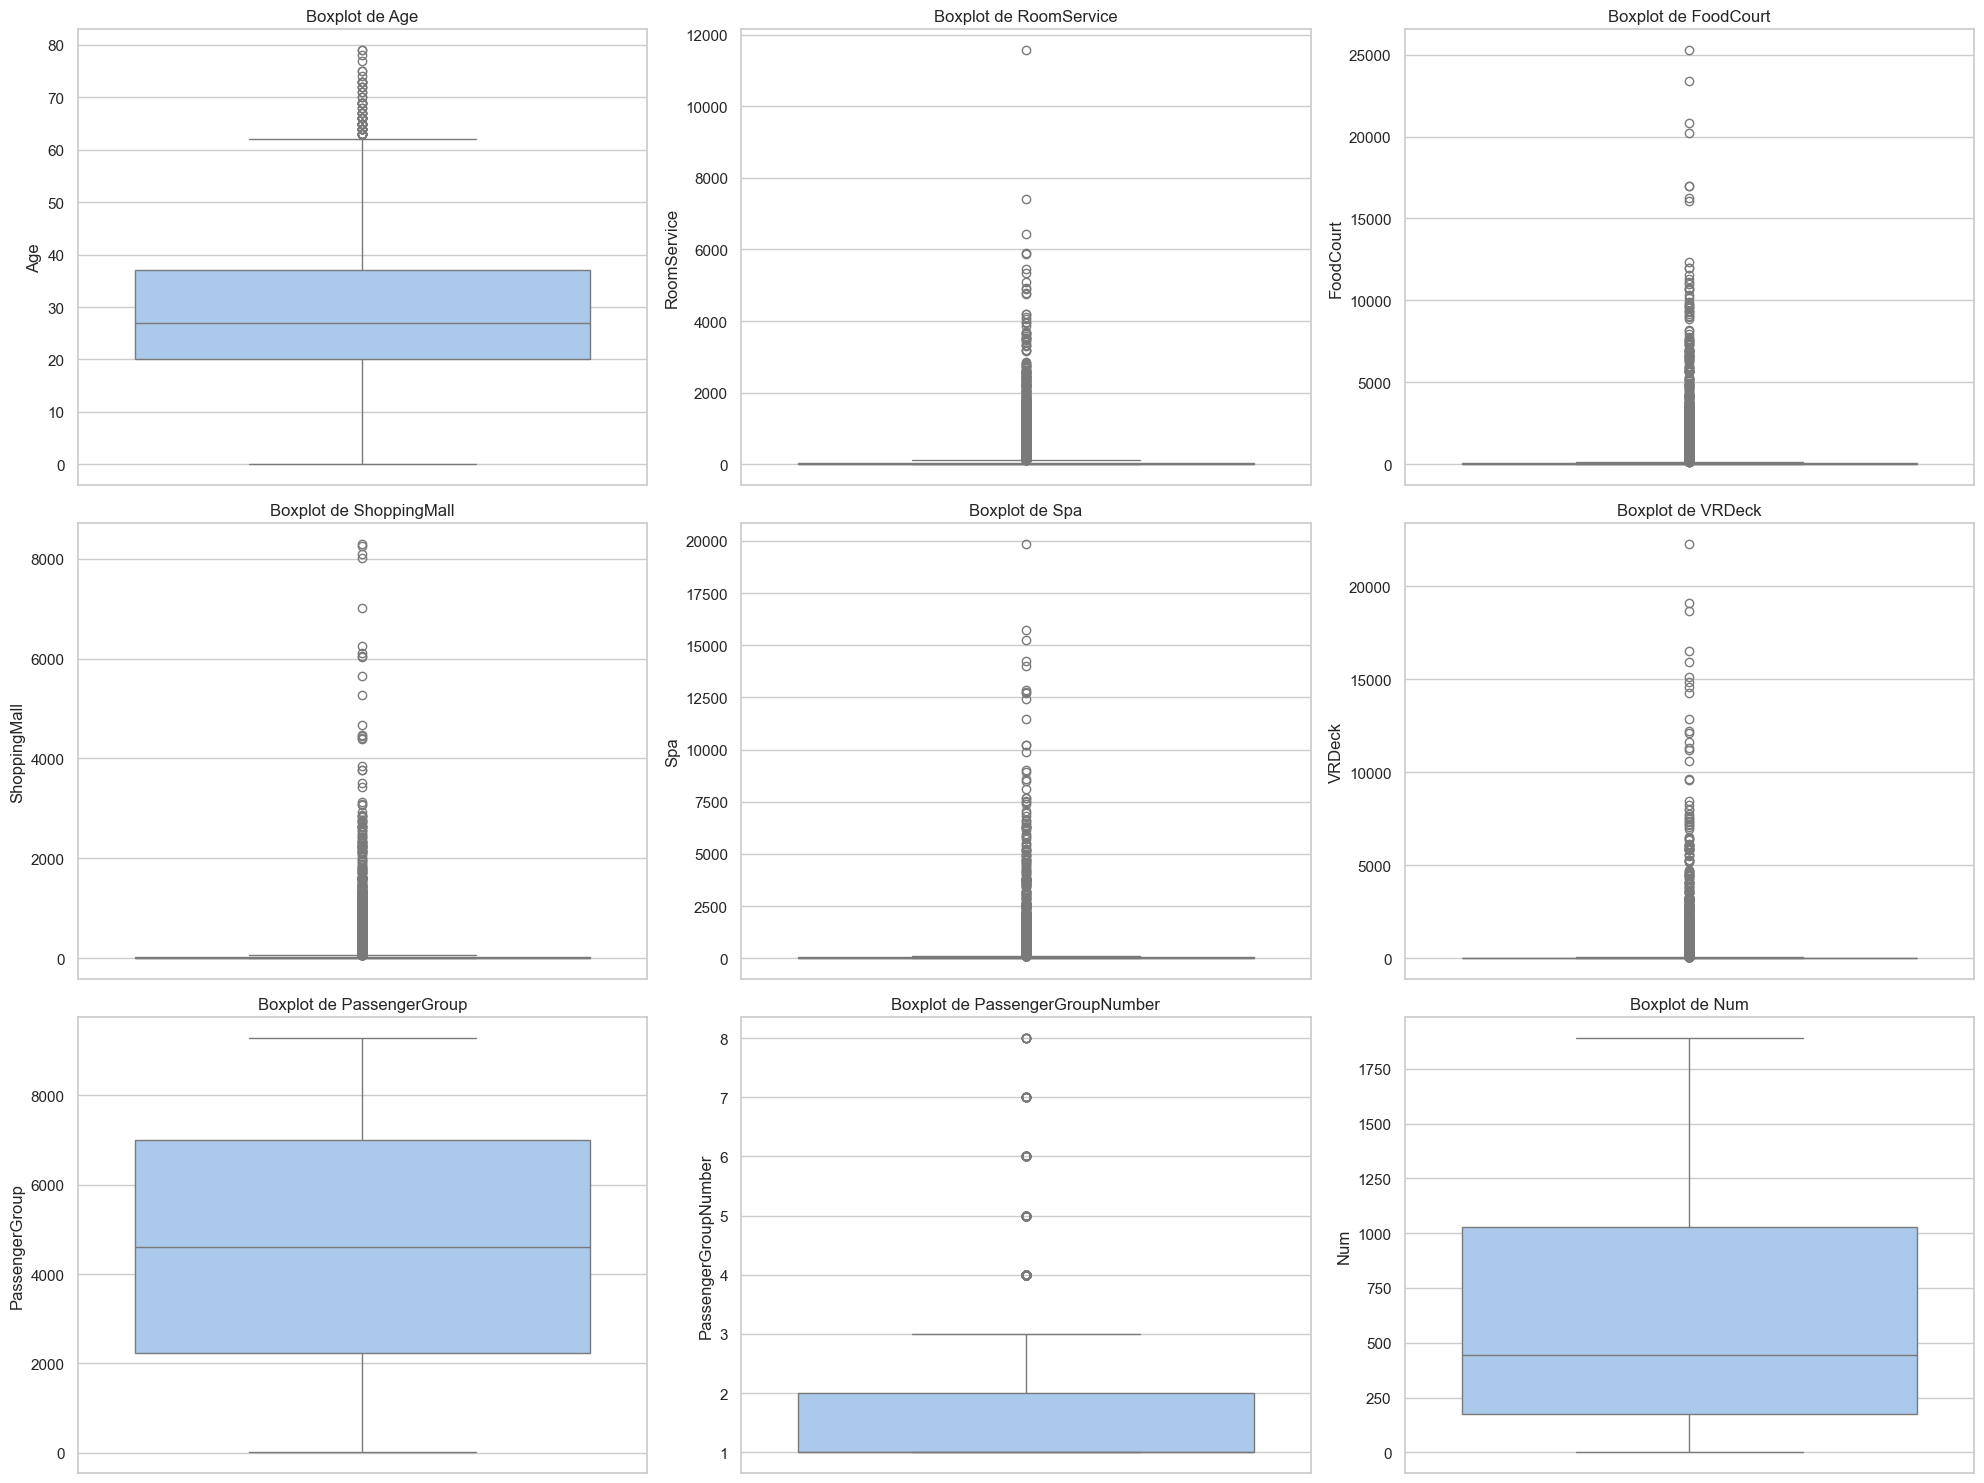

In [140]:
num2=df_test.select_dtypes(include='number')
columns = num2.columns

plt.figure(figsize=(20, 15)) 
for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=num2[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

#Idem que pour le précédent DataSet, on observe qu'il y a des outliers mais qui ne constituent pas des valeurs aberrantes. 

# II) Machine Learning

In [123]:
#L'idée est pour le sport de tester plusieurs algos de ML de classification et de pousser chaque étude au max en variant leurs hyperparamètres (GridSearchCV)
#A la fin on fera un tableau récapitulatif montrant les meilleurs scores de chacun pour permettre de décider duquel choisir. 
#Il me semble que dans le premier notebook, il y avait une boucle permettant de faire ça.  

NOTE : On veillera à regarder quelles sont les variables qui influent le plus sur ces algos de ML. Cela permettra de jouer sur leur étape de traitement des valeurs manquantes pour voir ce que ça fait vis a vis de l'accuracy

Aide pour NaNs : https://www.kaggle.com/competitions/spaceship-titanic/discussion/315987